# Project description

The telecom operator Interconnect would like to be able to forecast their churn of clients. In this project I will model the data to generate a good classifier with which we can discern which users are predicted to leave so that the relevant department at Interconnect can know which customers they need to engage to keep them from leaving.

# Loading needed libraries

In [1]:
# import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# import lgbm 
from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell

## Set environment variables

In [2]:
# set to display all output not only print() or last output
InteractiveShell.ast_node_interactivity = "all"

# set display all columns when showing dataframes
pd.options.display.max_columns = None

# Download the data

In [3]:
# load needed files, try/except to differentiate between running at home or on yandex jupyterhub
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    df_contract = pd.read_csv('contract.csv')
    df_internet = pd.read_csv('internet.csv')
    df_personal = pd.read_csv('personal.csv')
    df_phone = pd.read_csv('phone.csv')

## Briefly looking at the data

In [4]:
# display basic information about each of the dataframes we use
for df in [df_contract, df_internet, df_personal, df_phone]:
    df.info()
    df.sample(5)
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
816,6275-YDUVO,2019-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,86.20,178.7
2695,0254-KCJGT,2015-10-01,No,One year,Yes,Credit card (automatic),81.40,4354.45
3488,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.90,542.4
5429,9488-FVZCC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),79.50,5661.7
4556,3750-CKVKH,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,67.75,116.65


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5264,9488-FYQAU,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
259,5020-ZSTTY,DSL,Yes,Yes,No,Yes,Yes,Yes
3456,3059-NGMXB,DSL,Yes,Yes,No,No,No,Yes
2514,5960-MVTUK,DSL,No,No,No,Yes,No,No
260,9880-TDQAC,DSL,No,Yes,Yes,Yes,Yes,Yes


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
2013,7328-OWMOM,Female,0,No,Yes
6960,4690-PKDQG,Female,1,Yes,No
4990,4647-XXZAM,Female,0,Yes,Yes
4530,1945-XISKS,Female,0,Yes,No
2350,8739-XNIKG,Female,0,No,No


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
114,6734-PSBAW,Yes
4543,9103-TCIHJ,Yes
3029,8380-MQINP,No
1946,8051-HJRLT,No
644,9661-JALZV,Yes


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


# Data pre-processing

In this stage I'll merge the datasets, fill in missing data due to the merging, rename columns for easier work and create a standard 0/1 target value so I can perform better exploratory data analysis in the context of the target value. I'll also convert data types where needed/possible.

## Merging datasets

All 4 datasets have a one-to-one connection based on the customerID column, so I'll merge them into one.

In [5]:
# merge the 4 datasets into 1 on 'customerID'
df_all = df_personal.merge(df_contract, on='customerID', how='left')
df_all = df_all.merge(df_internet, on='customerID', how='left')
df_all = df_all.merge(df_phone, on='customerID', how='left')

## Filling missing data

When I merged the internet and phone information, users who didn't have such contracts got empty columns. I'll create a category of "no internet" for the type of internet of users with no contract, and "no" for all the boolean columns of registered services. The phone data only includes information about users who had 1 line (MultipleLines="No"), multiple lines (MultipleLines="Yes"), so users missing data in that column have no line at all, I'll fill this in temporarily as "zero" and later on I'll engineer a better feature based on this information.

In [6]:
# Print NaN number before modifications
df_all.isnull().sum().sum()

# Fill in type of internet as "no internet"
df_all['InternetService'].fillna('No internet', inplace=True)

# Fill boolean internet service columns with "No"
internet_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
df_all[internet_cols] = df_all[internet_cols].fillna('No')

# Fill missing MultipleLines columns
df_all['MultipleLines'].fillna('zero', inplace=True)

# Print NaN number after modifications
df_all.isnull().sum().sum()

11364

0

## Standardizing column names

I will rename columns to standardize them in the style I prefer - lowercase with underscore between words.

In [7]:
# rename columns
df_all.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']

## Create target column

Based on the `end_date` column, I'll convert all dates of leaving to 1 and all "No" values of users who didn't leave to 0.

In [8]:
# create target column
df_all['churned'] = (df_all['end_date'] != 'No').astype('int8')

# check numbers
df_all['churned'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churned, dtype: float64

As we've seen in the data exploration step when designing the workplan, we have a \~3:1 class imbalance.

## Converting data types

In this part I'll convert the `begin_date` column to datetime type and `total_charges` column to float.

In [9]:
# convert begin_date column to datetime column
df_all['begin_date'] = pd.to_datetime(df_all['begin_date'], format='%Y-%m-%d')

# convert total_charges column to float
df_all['total_charges'] = pd.to_numeric(df_all['total_charges'], errors='coerce', downcast='float')

The reason `total_charges` was loaded from the CSV as an object and not a float type is because some rows contained an empty string instead of a number. These were now converted to NaN, let's see if we can figure out how to fill these out.

In [10]:
df_all[df_all['total_charges'].isnull()]

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,zero,0
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No internet,No,No,No,No,No,No,No,0
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No internet,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,zero,0
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No internet,No,No,No,No,No,No,No,0
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No internet,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No internet,No,No,No,No,No,No,No,0
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No internet,No,No,No,No,No,No,No,0
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Apparently, these users all joined on the day that the data ends, so we obviously don't have information about total charges. As these are only 11 rows out of 7043 and they are not relevant to the period we are looking at, I will remove these from the dataset.

In [11]:
# remove rows where total_charges = NaN
df_all.dropna(subset=['total_charges'], inplace=True)
df_all.reset_index(inplace=True, drop=True)

# Exploratory data analysis

At this stage I'll be looking deeper into the data and visualizing it to decide what processing needs to be performed and give us insights in preparation of the modeling. I'll start by visualizing the differences for various features in regards to the churn status.

## Categorical feature differences correlating with churned status

I'll create helper functions to visualize the features in regards to the churned status.

In [12]:
# this function displays bar charts comparing the churned population with the non churned population
def check_categorical_features(df, features, cols=3):

    # count number of subplots needed
    num = len(features)
    rows = round(num/cols)

    # figure size depends on number of rows
    height = rows*6
    width = 15

    # create subplots
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height), sharey='row')

    # fill subplots
    for f, f_ax in zip(categorical_features, ax.ravel()):
        pd.crosstab(index=df[f], columns=df['churned'], normalize='columns').plot(kind='bar', ax=f_ax, title=f).set_xlabel('')
        f_ax.set_ylabel('Proportion')
    plt.setp(ax, ylim=[0,1])
    plt.tight_layout()

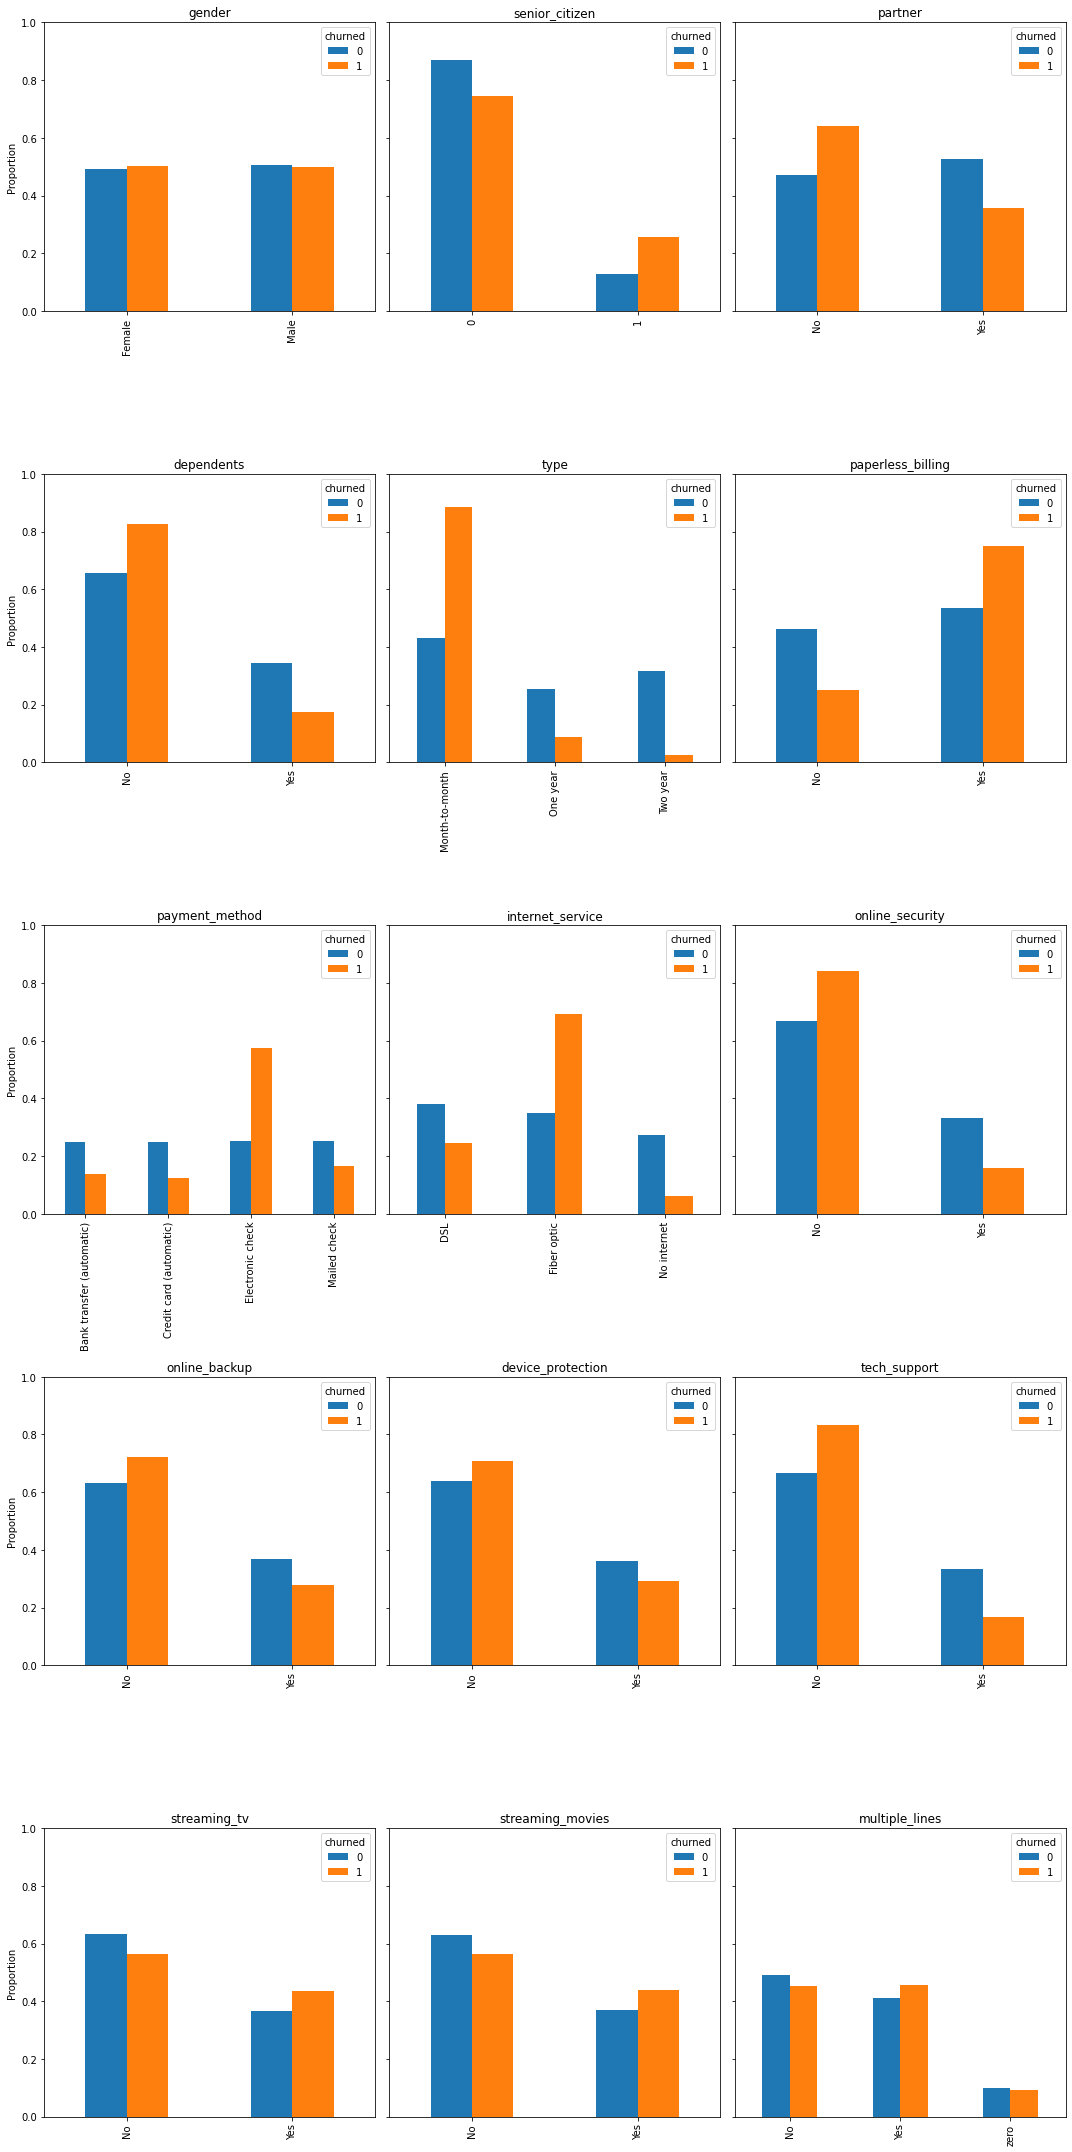

In [13]:
categorical_features = ['gender', 'senior_citizen', 'partner', 'dependents',
       'type', 'paperless_billing', 'payment_method', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

check_categorical_features(df_all, categorical_features)

Going over this, we can see that some features distributed the same or close to the same for churned and non-churned users, while others vary more widely. It is important to remember that these are correlations only, we do not know the causation relation between these features and leaving the telecom provider.

Let's see for each feature what we can deduce:
* `gender` - no difference between churned and non-churned.
* `senior_citizen` - we have a higher percentage of senior citizens in the churned group.
* `partner` - we have a higher percentage of singles in the churned group.
* `dependents` - we have a higher percentage of users without dependents in the churned group.
* `type` - churned users belonged mainly to the month-to-month package.
* `paperless_billing` - we have a higher percentage of users using paperless billing in the churned group.
* `payment_method` - churned users belonged mainly to the electronic check payment method.
* `internet_service` - churned users belonged mainly to the fiber optic internet service
* `online_security` - we have a higher percentage of churned users not use the online security service.
* `online_backup` - we have a somewhat higher percentage of churned users not use the online backup service.
* `device_protection` - we have a somewhat higher percentage of churned users not use the device protection service.
* `tech_support` - we have a higher percentage of churned users not use the tech support service.
* `streaming_tv` - we have a somewhat higher percentage of churned users use the TV streaming service.
* `streaming_movies` - we have a somewhat higher percentage of churned users use the movie streaming service.
* `multiple lines` - almost no difference between churned and non-churned users.

If we are resource restricted, it would be possible to remove the features which differ very slightly or not at all between the two groups from the modeling. I'll leave these in for now.

## Quantitative feature differences correlating with churned status

Now that we have looked at the categorical features, it's interesting also to look at the distribution of quantitative features between the two groups. The features we can look at here are the `begin_date`, `monthly_charges` and `total_charges`.

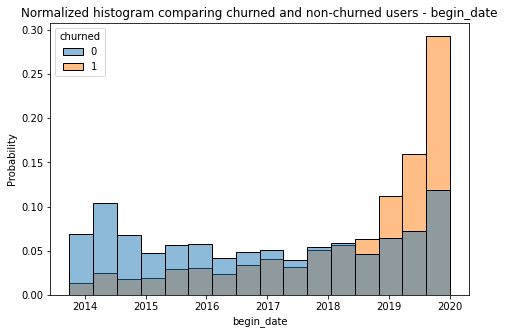

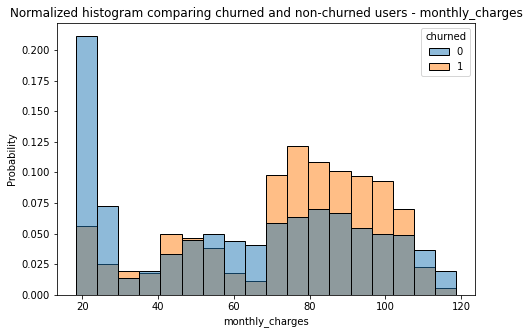

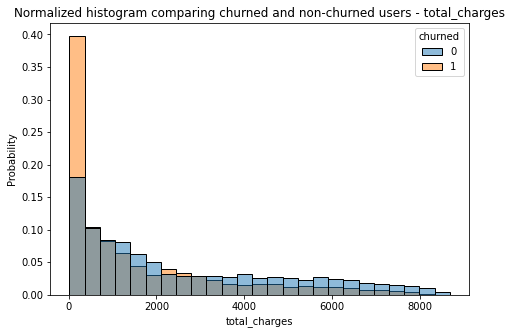

In [14]:
# plot normalized distribution for the 3 quantitative features
for feat in ['begin_date', 'monthly_charges', 'total_charges']:

    # create figure
    plt.figure(figsize=(7.5,5))
    
    # plot the histogram
    sns.histplot(df_all, x=feat, hue='churned', stat='probability', common_norm=False)
    
    # add title
    plt.title('Normalized histogram comparing churned and non-churned users - ' + str(feat))
    plt.show()
    
print(); # suppress unneeded output relating to figure creation etc.

Looking at these histograms, we can see that the two groups are obviously different.

* `begin_date` - on average, churned users are more recent joiners than non-churned users.
* `monthly_charges` - we can see that a large proportion of churned users had high monthly payments compared to non-churned users.
* `total_charges` - we can see that churned users have a much higher percentage of them in the lowest bin. This can probably be explained by the fact that most churned users are recent users (so less monthly number of charges). It could also have also been explained by the fact that these users left so in general they payed for less months than similar users who didn't leave, except that all the churning occurred in the last 4 months of the dataset.

## Statistical correlation of features with churned status

We have looked at connections visually, let's see what the correlation statistics are.

In [15]:
# create dataframe copy before performing changes.
df_copy = df_all.copy()

# convert boolean columns to boolean type so they will appear in the matrix
for c in categorical_features:
    options = df_copy[c].unique()
    
    if sorted(options) == ['No', 'Yes']:
        df_copy[c] = (df_copy[c] == 'Yes').astype('boolean')

# print correlation matrix in relation to 'churned'
corr_df = df_copy.corr()
corr_df['churned'].sort_values(ascending=False)

churned              1.000000
monthly_charges      0.192858
paperless_billing    0.191454
senior_citizen       0.150541
streaming_tv         0.063254
streaming_movies     0.060860
device_protection   -0.066193
online_backup       -0.082307
partner             -0.149982
dependents          -0.163128
tech_support        -0.164716
online_security     -0.171270
total_charges       -0.199484
Name: churned, dtype: float64

Of the numerical and boolean types we could analyse this way, we can see that the largest correlation factors exist for the features we already noticed above. High monthly charges correlate with churning, and so does the use of paperless billing, being a senior_citizen. On the negative size, the highest correlations with churning exist for low total charges, no online security plan, no tech support, no dependents and no having partner. Still, all these 1 vs 1 correlations have an absolute Pearson factor of < 0.2, which is not very impressive, but noticeable.

# Preparing data for supervised learning

In this part, I will engineer additional features and transform categorical variables using One Hot Encoding or some form of ordinal encoding. Then I'll divide the data into train/test and implement scaling of numeric variables based on the train set. 

Originally, I planned on performing class balancing by random oversampling, but instead I will use the built-in class-weights when training the models.

## Engineering additional features

One of the features which makes sense to me that could potentially influence the churned status is how long the user was registered. The most obvious way to calculate this is by subtracting `begin_date` from `end_date`. Unfortunately, `end_date` is our target, so using this feature would cause leakage of the target to the model. Instead, I will calculate month age of users based on dividing the `total_charges` by the average `monthly_charges`. 

In [16]:
# create a copy of the data before the heavy manipulations in the part
df_final = df_all.copy()

# create new feature representing length of registration in months
df_final['months_registered'] = df_final['total_charges'] / df_final['monthly_charges']

In addition, I'll extract the month from `begin_date` - there could be seasonality that the model could get from this value. Although `begin_date` contains both the month and year of begining and is available for use, together with the calculated months registered it would give the model the `end_date` too easily so I will omit the year information.

In [17]:
# create year of registration feature
df_final['begin_month'] = df_final['begin_date'].dt.month

## Preparing categorical features for modeling

I'll convert all "Yes/No" and such variables to 0/1 booleans, and use ordinal encoding or one hot encoding depending where approriate for the remaining categorical variables. I'll also remove the `customer_id` column as this is a random feature with no connection at all to the churn.

In [18]:
# convert all "yes/no" variables to 0/1 int. Not using boolean type due to some bugs in some of the scikit packages.
for c in categorical_features:
    options = df_final[c].unique()
    
    if sorted(options) == ['No', 'Yes']:
        df_final[c] = (df_final[c] == 'Yes').astype('int8')
        
# shrink 0/1 senior_citizen to int8
df_final['senior_citizen'] = df_final['senior_citizen'].astype('int8')
        
# convert non-ordinal categorical columns using OHE
df_final = pd.get_dummies(df_final, columns=['gender','type','payment_method','internet_service'], drop_first=True)

# rename new columns to standardize
df_final.rename(columns={'gender_Male': 'gender_male',
                         'type_One year': 'type_1y',
                         'type_Two year': 'type_2y',
                         'payment_method_Credit card (automatic)': 'payment_ccard',
                         'payment_method_Electronic check': 'payment_electronic',
                         'payment_method_Mailed check': 'payment_check',
                         'internet_service_Fiber optic': 'internet_fiber',
                         'internet_service_No internet': 'internet_none'}, inplace=True)

# encode 'multiple_lines' ordinally. Manual is easiest here
lines_dict = {'zero' : 0, 'No' : 1, 'Yes' : 2}
df_final['num_lines'] = df_final['multiple_lines'].map(lines_dict)

# dropping the unneeded columns
df_final.drop(columns=['customer_id', 'end_date', 'multiple_lines', 'begin_date'], inplace=True)

## Dividing data into train/test sets

I will use a 4:1 division of the data into train/test.

In [19]:
# divide data 4:1 using stratify=True
x_train, x_test, y_train, y_test = train_test_split(df_final.drop(columns=['churned']), df_final['churned'], test_size=0.2, random_state=13, stratify=df_final['churned'])

## Scaling of numerical features

Since I am planning on performing cross validation, to limit data leakage between the train and validation folds I will create a preprocessing step that includes scaling the data, but it will be performed based on each training fold and not globally on the whole training set at this point. 

In [20]:
# choose which columns to scale
num_cols = ['monthly_charges', 'total_charges', 'months_registered', 'begin_month']

# define possible transformers
scaler = StandardScaler()

# define column transformer for pipeline
preprocess = make_column_transformer(
    (scaler, num_cols),
    remainder='passthrough')

# Modeling and hyperparameter tuning

In this stage I will create the models and perform hyperparameter tuning where realistic using cross validation. I'll begin by defining a helper function as this part is identical between models.

In [21]:
def tune_model(model, param_grid, x_train, y_train):
    
    # define pipeline
    steps = [('preprocessing', preprocess), ('model', model)]
    pipeline = Pipeline(steps)

    # create stratified cross validation folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    
    # define grid search model
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
    
    # perform the search
    grid_result = grid_search.fit(x_train, y_train)
    
    # get scores for this model
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return grid_result, params

## Logistic regression

In [22]:
# define model
model_lr = LogisticRegression(class_weight='balanced')

# define parameters to search through
solvers = ['newton-cg', 'lbfgs', 'liblinear']
params = dict(model__solver=solvers)

# perform hyperparameter tuning
grid_result_lr, params_lr = tune_model(model_lr, params, x_train, y_train)

Best: 0.845167 using {'model__solver': 'lbfgs'}
0.845163 (0.006961) with: {'model__solver': 'newton-cg'}
0.845167 (0.006961) with: {'model__solver': 'lbfgs'}
0.845019 (0.007092) with: {'model__solver': 'liblinear'}


## Random forest

In [23]:
# define model
model_rf = RandomForestClassifier(class_weight='balanced')

# define parameters to search through
#criterion = ['gini', 'entropy', 'log_loss'] # 'log_loss' option doesn't work with older RF version on platform.
criterion = ['gini', 'entropy']
n_estimators = range(10, 51, 10)
max_depth = range(3, 40, 5)
params = dict(model__criterion=criterion, model__n_estimators = n_estimators, model__max_depth = max_depth)

# perform hyperparameter tuning
grid_result_rf, params_rf = tune_model(model_rf, params, x_train, y_train)

Best: 0.879315 using {'model__criterion': 'gini', 'model__max_depth': 18, 'model__n_estimators': 50}
0.833390 (0.006911) with: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__n_estimators': 10}
0.842231 (0.011305) with: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__n_estimators': 20}
0.844618 (0.006204) with: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__n_estimators': 30}
0.844056 (0.004704) with: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__n_estimators': 40}
0.845173 (0.007588) with: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__n_estimators': 50}
0.862398 (0.011313) with: {'model__criterion': 'gini', 'model__max_depth': 8, 'model__n_estimators': 10}
0.866707 (0.006330) with: {'model__criterion': 'gini', 'model__max_depth': 8, 'model__n_estimators': 20}
0.868062 (0.008412) with: {'model__criterion': 'gini', 'model__max_depth': 8, 'model__n_estimators': 30}
0.869940 (0.004955) with: {'model__criterion': 'gini', 'mod

## LGBMClassifier

In [24]:
# define model
model_lgbm = LGBMClassifier(class_weight='balanced', objective='binary')

# define parameters to search through
boosting_type = ['gbdt', 'dart', 'goss']
learning_rate = [0.025, 0.05, 0.075, 0.1]
min_data_in_leaf = [10, 100, 500, 1000]
params = dict(model__boosting_type=boosting_type, model__learning_rate = learning_rate, model__min_data_in_leaf = min_data_in_leaf)

# perform hyperparameter tuning
grid_result_lgbm, params_lgbm = tune_model(model_lgbm, params, x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warnin

The best model based on the cross validation is the LGBMclassifier() model with a max ROC-AUC score of 0.94.

# Testing the models on the test set

I will now use the parameters we found above to train the best model on the whole training set, then predict the test targets and finally compare the results by calculating the roc-auc score on the unseen data in the test set. For reference, I will also include the 2 other less effective models. I will also time the modeling and add an additional score in the form of F1 score. We were asked to calculate the accuracy of the models, which I will, but as this is an imbalanced classification problem, the F1 score gives us a better way to score the models. I'll post both results.

## Performing the testing

In [25]:
# define lists to store timing and scores
training_time = []
predicting_time = []
roc_auc_scores = []
f1_scores = []
acc_scores = []

# define all the models with optimal parameters
models = [DummyClassifier(strategy='prior'),
          grid_result_lr.best_estimator_.named_steps['model'],
          grid_result_rf.best_estimator_.named_steps['model'],
          grid_result_lgbm.best_estimator_.named_steps['model']]

# define all model names
model_names = ['DummyClassifier()', 'LogisticRegression()', 'RandomForestClassifier()', 'LGBMClassifier()']

In [26]:
# perform scaling on whole train dataset and on test set based on the train set
scaler = grid_result_lr.best_estimator_.named_steps['preprocessing'] # the preprocessing step is identical for all
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# perform training on full train dataset
for estimator in models:

    # training
    timing_train = %timeit -n3 -r3 -o estimator.fit(x_train_scaled, y_train)
    training_time.append(timing_train.average)
    
    # predict test results and probabilities for roc_auc
    preds_proba = estimator.predict_proba(x_test_scaled)[:, 1]
    preds = estimator.predict(x_test_scaled)
    timing_pred = %timeit -n3 -r3 -o estimator.predict(x_test_scaled) # time the prediction step
    predicting_time.append(timing_pred.average)
    
    # calculate scores
    roc_auc_scores.append(roc_auc_score(y_test, preds_proba))
    f1_scores.append(f1_score(y_test, preds))
    acc_scores.append(accuracy_score(y_test, preds))
    

143 µs ± 23.2 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
27.4 µs ± 6.07 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
68.1 ms ± 1.18 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
84.3 µs ± 13.9 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
225 ms ± 11.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
11.4 ms ± 259 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
192 ms ± 4.68 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
12.3 ms ± 7.26 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Results analysis

Having timed the different steps and retained the scores, we will now analyze the results.

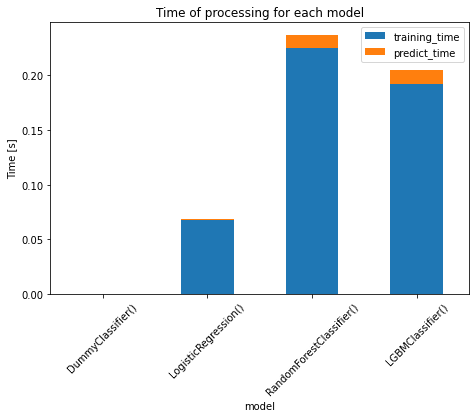

In [27]:
# arrange results together
df_results = pd.DataFrame([model_names, training_time, predicting_time, roc_auc_scores, f1_scores, acc_scores]).T
df_results.columns = ['model', 'training_time', 'predict_time', 'roc_auc_scores', 'f1_scores', 'acc_scores']
df_results

# plot bar chart of training and prediction time
df_results.plot(kind='bar', stacked=True, x='model', y=['training_time','predict_time'], figsize=(7.5,5), title='Time of processing for each model')
plt.ylabel('Time [s]')
plt.xticks(rotation=45);

We can see that all models in general are pretty fast, with both training and prediction time totalling less than a quarter of a second for even the "slowest" of the models, the random forest. Among the real models, the logistic regression model is the fastest to perform the computations.

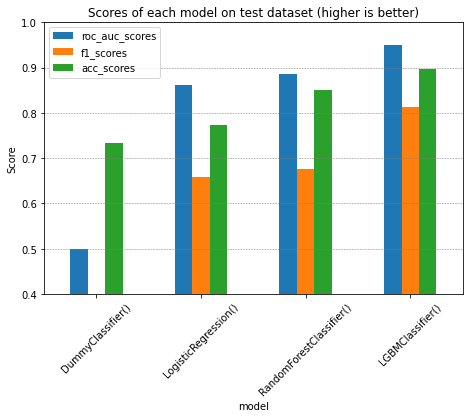

In [28]:
# plot bar chart of scores
df_results.plot(kind='bar', x='model', y=['roc_auc_scores', 'f1_scores', 'acc_scores'], figsize=(7.5,5), title='Scores of each model on test dataset (higher is better)')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, axis='y')
plt.ylabel('Score')
plt.ylim(0.4,1)
plt.xticks(rotation=45);

In [29]:
df_results

,model,training_time,predict_time,roc_auc_scores,f1_scores,acc_scores
0,DummyClassifier(),0.000143,0.000027,0.5,0.0,0.734186
1,LogisticRegression(),0.068114,0.000084,0.861472,0.658824,0.773276
2,RandomForestClassifier(),0.225169,0.011399,0.886598,0.675926,0.850746
3,LGBMClassifier(),0.192111,0.012342,0.949141,0.812987,0.897655


As mentioned above, due to the imbalanced labels, the accuracy score is problematic and this can be seen here, as the dummy model which just assigns the most common class as the prediction gives us an accuracy of 0.734. I'll ignore the rest of the accuracy scores.

We can see all of our real models perform much better than the sanity check. We reached \~0.95 ROC-AUC score for the LGBMclassifier() model, which shows that it wasn't overfitted on the training/validation set. The score is even a little bit higher than it was on the training/validation set. The other two models also reached scores close to what they reached on the training/validation set.

Looking at the F1 scores, it follows the same order of results we saw as in ROC-AUC, the LGBM classifier takes the lead again, with \~0.81, while the other two models reach lower scores of \~0.68 and \~0.66.

# Conclusions and summary

Taking both the scores and the time and model complexity into account, the LGBM classifier is the best model for Interconnect's needs. It has the highest AUC-ROC score, the highest F1 score and while it takes longer to train/predict than the logistic regression model, we are still talking about less than a quarter of a second which is insignificant compared to the added correctness of the predictions it generates.

To sum up, I downloaded the data, took a brief look at it and then:

* **Preprocessing**:
    * merged the different datasets into one based on `customer_id`
    * filled in missing data due to the merging
    * standardized column names to lowercase and underscore between words
    * created the `churned` 0/1 column based on `end_date`
        * noticed a 3:1 class imbalance in favor of the negative class
    * converted `begin_date` to datetime and `total_charges` to float type
        * 11 observations had missing `total_charges` due to joining on the last day of the data, and were dropped

* **Exploratory data analysis**:
    * looked graphically at categorical feature differences in regards to churned status which showed us which features could be important in the modeling stage
    * analyzed the histograms of `begin_date`, `total_charges` and `monthly_charges` comparing between the churned statuses 
        * discovered churned users are usually more recent, had higher monthly charges and lower total charges
    * looked at the correlation matrix vs churned status to confirm the correlations, noticing the highest absolute Pearson correlation of features 1 to 1 vs churned status to be below 0.2.

* **Preparing data for supervised learning**:
    * engineered a few extra features which might be helpful
        * `months_registered` as the ratio of total charges to monthly charges, representing how long users were registered
        * `begin_month` as features that might show seasonality in regards to churning
    * converted all Yes/No categorical features to 0/1 int types
    * converted `multiple lines` to a 0/1/2 value `num_lines` representing how many phone lines the user has
    * dropped unneeded columns (`customer_id`, `end_date`, `multiple_lines` and `begin_date`)
    * performed dummy encoding / OHE for the `gender`, `type`, `payment_method` and `internet_service` features
    * divided the data 4:1 between train/validation and test sets
    * prepared a pre-processing step for the modeling pipelines that scales all numerical features using StandardScaler()

* **Modeling and hyperparameter tuning**:
    * created a helper function to perform the repetitive parts of hyperparameter tuning
    * tuned parameters for 3 different functions using GridSearch cross validation via 5 StratifiedKfold folds:
        * LogisticRegression: tuned the solver parameter
        * RandomForestClassifier: tuned the criterion, n_estimators and max_depth parameters
        * LGBMClassifier: tuned the boosting_type, learning_rate and min_data_in_leaf parameters
    * to deal with the class imbalance, all models were trained with class_weight='balanced', giving extra weight to the rare class observations.
    * the LGBMClassifier model had the highest score with 0.94 maximum AUC-ROC score.

* **Testing the models**:
    * used the above optimal parameters train the models on the full training set
    * as a sanity check, added a DummyClassifier() that always predicts the most common class
    * noticed that in terms of learning and prediction time, RF > LGBM > LR, but all models took less than 0.25 seconds
    * noticed that as expected the accuracy score is not good enough for imbalanced classification problems
    * achieved AUC-ROC scores of 0.95 for the LGBM model, with the next best model being RF and last LR
    * achieved F1 scores of \~0.68 for RF, \~0.66 for LR and \~0.81 for LGBM

# Project report

In this part I'll answer the questions we've been asked to include in the report. I've included the markdown all through the code explaining my reasoning and choices and the results I've achieved there.

**What steps of the plan were performed and what steps were skipped (explain why)?**

In general, all steps were performed as per the workplan. Some steps were moved around a little bit. For example, I was planning on first performing EDA and then processing the data, but some of the processing steps (such as merging the 4 tables together) were performed ahead of the EDA so I could more easily perform the EDA.

In addition, I was originally planning to augment the data using the imbalanced learning package to fix the class imbalance in the training set, but I tried first using the class_weights option in the models which is the easiest to implement and my results were good enough without needing to augment the data so I skipped that step.

Lastly, I was planning to choose the winning model out of the final 3 tuned models based on the results on the test set but the reviewer said this means my results will then be biased. Due to other changes the CV results showed a clear winning model based on the train set, so in the end I only used the test scores to make sure there was no obvious overfitting issue with the LGBM model I used.

**What difficulties did you encounter and how did you manage to solve them?**

One of the difficulties I encountered was performing this project without having leakage of the target to the features. Since the `begin_date`, `monthly_charges` and `total_charges` together can be combined to get to the `end_date`, the dataset contained an inherent leak. I decided to only encode part of the `begin_date` feature (the month without the year) so I can take into account seasonality in registration over the year without giving away the target.

Other than that, this project was pretty straightforward and easier than what my expectations were for a final project that emcompasses all we've learned during this course.

**What were some of the key steps to solving the task?**

The key steps in my opinion were engineering the feature of the monthly age of the users which was important in regards to getting a better AUC-ROC score, and using class_weights to skip having to deal with data augmentation. In addition, using cross validation hyperparameter tuning and encoding the month of joining allowed my models to go from 0.6-0.85 to 0.84-0.95 AUC-ROC scores in combination with the rest of the features, so that was a big help as well. 

There were other things I was thinking of trying if my initial runs would have given me lower scores in the models, such as unsupervised learning to find hidden groups, more advanced data augmentation steps, trying out other models and/or using their own encoding methods for categorical and numerical values, changing from dummy encoding (drop_first=True) to real OHE (drop_first=False) to help the tree based models get a little bit more out of the data etc. Fortunately, the scores I got were good enough without these additional steps.

**What is your final model and what quality score does it have?**

The final model is an LGBMClassifier() with the following parameters:
* class_weight: 'balanced'
* objective: 'binary'
* boosting_type: 'gbdt'
* learning_rate: 0.1
* min_data_in_leaf: 100

The scores I got for this model:
* ROC-AUC score: 0.949141
* F1 score: 0.812987
* Accuracy score: 0.897655